In [31]:
import tarfile
import os
import nltk
import numpy as np
import numpy.matlib
import scipy
import sklearn 
import sklearn.decomposition
import matplotlib.pyplot as plt
import sklearn.manifold
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger') 
nltk.download('wordnet') 
nltk.download('stopwords')
nltk.download('omw-1.4')
lemmatizer = nltk.stem.WordNetLemmatizer() 

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Vera\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Vera\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Vera\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Vera\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Vera\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# 11.1

Importing and preparing the data

In [32]:
topics = ['rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey']
newsgroup_topics_documents = []
for topic in topics:
    path_to_topic = 'C:/disk_D/1_tampere_uni/text data analysis/hw/6/20_newsgroups/' + topic
    topic_documents_names = os.listdir(path_to_topic)[:700]
    topic_documents = []
    for topic_document_name in topic_documents_names:
        document_file = open(path_to_topic + '/' + topic_document_name, 'r')
        document = document_file.read()
        document_file.close()
        newsgroup_topics_documents.append(document)

In [33]:
excludedlinemarkers=['Xref:','Path:','From:','Newsgroups:','Subject:','Summary:', \
                     'Keywords:','Message-ID:','Date:','Expires:','Followup-To:','Distribution:', \
                     'Organization:','Approved:','Supersedes:','Lines:','NNTP-Posting-Host:', \
                     'References:','Sender:','In-Reply-To:','Article-I.D.:','Reply-To:', \
                     'Nntp-Posting-Host:'] 

for d_document in range(len(newsgroup_topics_documents)):
    templines = newsgroup_topics_documents[d_document].splitlines()    
    remaininglines = []    
    for l in range(len(templines)):        
        line_should_be_excluded = 0        
        for m in range(len(excludedlinemarkers)):            
            if len(templines[l]) >= len(excludedlinemarkers[m]):                
                if excludedlinemarkers[m] == \
                                templines[l][0:len(excludedlinemarkers[m])]:                    
                    line_should_be_excluded=1                    
                    break        
        if line_should_be_excluded == 0:           
            remaininglines.append(templines[l])    
    newsgroup_topics_documents[d_document] = '\n'.join(remaininglines)

In [34]:
def tokenize_text(text):
    
    temp_tokenizedtext = nltk.word_tokenize(text)    
    mycrawled_nltktext = nltk.Text(temp_tokenizedtext)    
    
    return mycrawled_nltktext


def lower_case_text(text):
    mycrawled_lowercasetext = [] 

    for k in range(len(text)):        
        lowercaseword = text[k].lower()        
        mycrawled_lowercasetext.append(lowercaseword)    
        
    return mycrawled_lowercasetext

def tagtowordnet(postag):   
    wordnettag = -1   
    if postag[0] == 'N':        
        wordnettag = 'n'   
    elif postag[0] == 'V':        
        wordnettag = 'v'   
    elif postag[0] == 'J':        
        wordnettag = 'a'    
    elif postag[0] == 'R':        
        wordnettag = 'r'    
    return(wordnettag)

def lemmatizetext(nltktexttolemmatize):    
    # Tag the text with POS tags    
    taggedtext = nltk.pos_tag(nltktexttolemmatize)   
    # Lemmatize each word text    
    lemmatizedtext = []    
    for l in range(len(taggedtext)):       
        # Lemmatize a word using the WordNet converted POS tag       
        wordtolemmatize = taggedtext[l][0]        
        wordnettag = tagtowordnet(taggedtext[l][1])        
        if wordnettag != -1:            
            lemmatizedword = lemmatizer.lemmatize(wordtolemmatize,wordnettag)        
        else:            
            lemmatizedword=wordtolemmatize       
            # Store the lemmatized word        
        lemmatizedtext.append(lemmatizedword)
        
    return(lemmatizedtext) 


In [35]:
def prune_text(mycrawled_lemmatizedtexts, unifiedvocabulary, myindices_in_unifiedvocabulary,  highest_totaloccurrences_indices, occur_counts):
    nltkstopwords=nltk.corpus.stopwords.words('english') 
    pruningdecisions = np.zeros((len(unifiedvocabulary),1)) 
    for k in range(len(unifiedvocabulary)):    
        # Rule 1: check the nltk stop word list    
        if (unifiedvocabulary[k] in nltkstopwords):        
            pruningdecisions[k] = 1    
            
        # Rule 2: if the word is in the top 1% of frequent words    
        if (k in highest_totaloccurrences_indices[\
                                                  0:int(np.floor(len(unifiedvocabulary)*0.01))]):        
            pruningdecisions[k] = 1    
        # Rule 3: if the word is too short    
        if len(unifiedvocabulary[k]) < 2:        
            pruningdecisions[k] = 1    
            
        # Rule 4: if the word is in the bottom 65% of frequent words    
        if (k in highest_totaloccurrences_indices[(int(np.floor(\
                                                                len(unifiedvocabulary)*0.35))):len(unifiedvocabulary)]):        
            pruningdecisions[k]=1     
            
        # Rule 5: if the word is too long    
        if len(unifiedvocabulary[k])>20:        
            pruningdecisions[k] = 1    
            
        # Rule 6: if the word appears less than 4 times
        if occur_counts[k] < 4:
            pruningdecisions[k] = 1  
            
        if unifiedvocabulary[k].isalpha() == False:        
            pruningdecisions[k]=1
         
    oldtopruned = [] 
    tempind = -1 
    for k in range(len(unifiedvocabulary)):    
        if pruningdecisions[k] == 0:        
            tempind = tempind + 1        
            oldtopruned.append(tempind)    
        else:        
            oldtopruned.append(-1) 
    #%% Create pruned texts 
    mycrawled_prunedtexts = [] 
    myindices_in_prunedvocabulary = [] 
    for k in range(len(mycrawled_lemmatizedtexts)):       
        temp_newindices = []    
        temp_newdoc = []    
        for l in range(len(mycrawled_lemmatizedtexts[k])):        
            temp_oldindex = myindices_in_unifiedvocabulary[k][l]                    
            temp_newindex = oldtopruned[temp_oldindex]        
            if temp_newindex != -1:            
                temp_newindices.append(temp_newindex)            
                temp_newdoc.append(unifiedvocabulary[temp_oldindex])    
        mycrawled_prunedtexts.append(temp_newdoc)    
        myindices_in_prunedvocabulary.append(temp_newindices)
    
    remainingindices = np.squeeze(np.where(pruningdecisions == 0)[0]) 
    remainingvocabulary = unifiedvocabulary[remainingindices] 
    return mycrawled_prunedtexts, myindices_in_prunedvocabulary, remainingvocabulary

In [36]:
newsgroup_texts = []
for document in newsgroup_topics_documents:
    text = " ".join(document.split())
    newsgroup_texts.append(text)
    
newsgroups_tokenized = []
for document in newsgroup_texts:
    document = tokenize_text(document)
    newsgroups_tokenized.append(document)
    

newsgroups_lower = []
for document in newsgroups_tokenized:
    document = lower_case_text(document)
    newsgroups_lower.append(document)
    

newsgroups_texts_lemmatized = []
for document in newsgroups_lower:
    document = lemmatizetext(document)
    document = nltk.Text(document)
    newsgroups_texts_lemmatized.append(document)

In [38]:
vocabularies = [] 
indices_in_vocabularies = []
# Find the vocabulary of each document 
for document in newsgroups_texts_lemmatized:   
    # Get unique words and where they occur       
    uniqueresults = np.unique(document,return_inverse=True)    
    uniquewords = uniqueresults[0]    
    wordindices = uniqueresults[1]    
    # Store the vocabulary and indices of document words in it    
    vocabularies.append(uniquewords)    
    indices_in_vocabularies.append(wordindices) 
    
tempvocabulary = []  
for document in newsgroups_texts_lemmatized:   
    tempvocabulary.extend(document) 
    # Find the unique elements among all vocabularies 
uniqueresults = np.unique(tempvocabulary,return_inverse=True) 
unifiedvocabulary = uniqueresults[0] 
wordindices = uniqueresults[1] 
# Translate previous indices to the unified vocabulary. 
# Must keep track where each vocabulary started in 
# the concatenated one. 
vocabularystart = 0 
indices_in_unifiedvocabulary = [] 
for k in range(len(newsgroups_texts_lemmatized)):    
    # In order to shift word indices, we must temporarily    
    # change their data type to a Numpy array    
    tempindices = np.array(indices_in_vocabularies[k])    
    tempindices = tempindices + vocabularystart    
    tempindices = wordindices[tempindices]    
    indices_in_unifiedvocabulary.append(tempindices)    
    vocabularystart = vocabularystart + len(vocabularies[k])
    
unifiedvocabulary_totaloccurrencecounts = np.zeros((len(unifiedvocabulary),1)) 

for k in range(len(newsgroups_texts_lemmatized)): 
    occurrencecounts = np.zeros((len(unifiedvocabulary),1))    
    for l in range(len(indices_in_unifiedvocabulary[k])):        
        occurrencecounts[indices_in_unifiedvocabulary[k][l]] = \
        occurrencecounts[indices_in_unifiedvocabulary[k][l]] + 1    
    unifiedvocabulary_totaloccurrencecounts = \
    unifiedvocabulary_totaloccurrencecounts + occurrencecounts  

highest_totaloccurrences_indices = np.argsort(\
                                               -1*unifiedvocabulary_totaloccurrencecounts,axis=0) 

newsgroups_pruned_texts, vocabulary_pruned_indices, vocabulary_pruned = prune_text(newsgroups_texts_lemmatized, unifiedvocabulary, 
                                                                                  indices_in_unifiedvocabulary, 
                                                                                  unifiedvocabulary_totaloccurrencecounts,
                                                                                  highest_totaloccurrences_indices)
                                                                                 

Calculating the tf-idf matrix for pruned text and its vocabulary

In [39]:
n_docs = len(newsgroups_pruned_texts) 
n_vocab = len(vocabulary_pruned) 
# Matrix of term frequencies 
tfmatrix_len_norm = scipy.sparse.lil_matrix((n_docs,n_vocab))
# Row vector of document frequencies 
dfvector = scipy.sparse.lil_matrix((1,n_vocab)) 
# Loop over documents 
for k in range(n_docs):   
    # Row vector of which words occurred in this document  
    temp_dfvector = scipy.sparse.lil_matrix((1,n_vocab))   
    temp_total_terms = len(np.unique(newsgroups_pruned_texts[k]))
    # Loop over words    
    for l in range(len(newsgroups_pruned_texts[k])):        
    # Add current word to term-frequency count and document-count        
        currentword = vocabulary_pruned_indices[k][l]   
        tfmatrix_len_norm[k,currentword] += 1  
        temp_dfvector[0,currentword] = 1  
    # Length normalization frequence of raw counts
    tfmatrix_len_norm[k, :] /= temp_total_terms
    # Add which words occurred in this document to overall document counts
    dfvector += temp_dfvector
    # Use the count statistics to compute the tf-idf matrix 
# Let's use length-normalized frequency term count, and smoothed logarithmic idf 


In [40]:
idfvector = 1 + np.log((1 / (np.array(dfvector.todense())[0] + 1)) * n_docs)
tfidfmatrix = scipy.sparse.lil_matrix((n_docs,n_vocab)) 
for k in range(n_docs):    
    tfidfmatrix[k,:] = tfmatrix_len_norm[k,:] * idfvector


Calculating the tf-idf matrix for not pruned texts and vocabulary

In [8]:
n_docs = len(newsgroups_pruned_texts) 
n_vocab_1 = len(unifiedvocabulary) 
# Matrix of term frequencies 
tfmatrix_len_norm_1 = scipy.sparse.lil_matrix((n_docs,n_vocab_1))
# Row vector of document frequencies 
dfvector_1 = scipy.sparse.lil_matrix((1,n_vocab_1)) 
# Loop over documents 
for k in range(n_docs):   
    # Row vector of which words occurred in this document  
    temp_dfvector = scipy.sparse.lil_matrix((1,n_vocab_1))   
    temp_total_terms = len(np.unique(indices_in_unifiedvocabulary[k]))
    # Loop over words    
    for l in range(len(indices_in_unifiedvocabulary[k])):        
    # Add current word to term-frequency count and document-count        
        currentword = indices_in_unifiedvocabulary[k][l]   
        tfmatrix_len_norm_1[k,currentword] += 1  
        temp_dfvector[0,currentword] = 1  
    # Length normalization frequence of raw counts
    tfmatrix_len_norm_1[k, :] /= temp_total_terms
    # Add which words occurred in this document to overall document counts
    dfvector_1 += temp_dfvector
    # Use the count statistics to compute the tf-idf matrix 
# Let's use length-normalized frequency term count, and smoothed logarithmic idf 


In [9]:
idfvector_1 = 1 + np.log((1 / (np.array(dfvector_1.todense())[0] + 1)) * n_docs)
tfidfmatrix_without_pruning = scipy.sparse.lil_matrix((n_docs,n_vocab_1)) 
for k in range(n_docs):    
    tfidfmatrix_without_pruning[k,:] = tfmatrix_len_norm_1[k,:] * idfvector_1

In [41]:
X = tfidfmatrix.copy()

Creating PSA and plotting it

In [42]:
svdmodel=sklearn.decomposition.TruncatedSVD(n_components=2, n_iter=70, random_state=42)

In [43]:
documentplot = svdmodel.fit(X).transform(X)

In [44]:
# Plot projected documents 
svdmodel=sklearn.decomposition.TruncatedSVD(n_components=2, n_iter=70, random_state=42) 
documentplot = svdmodel.fit(X).transform(X) 

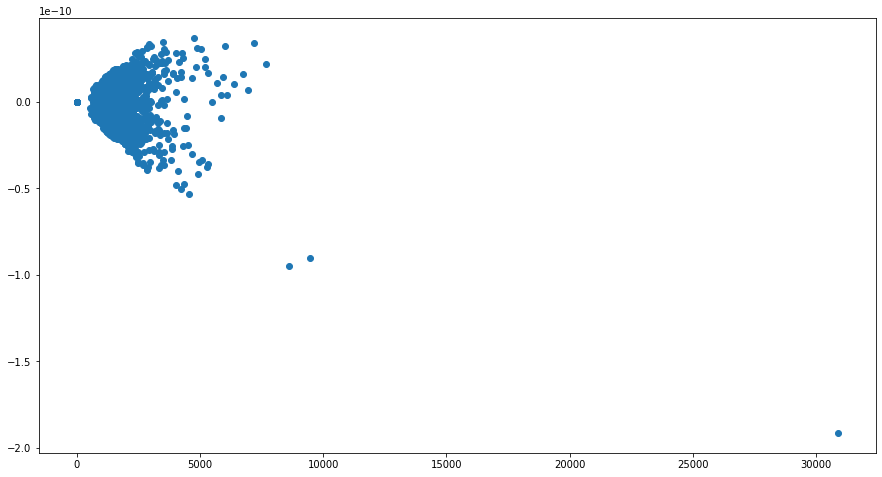

In [45]:
plt.figure(figsize=(15, 8))
plt.scatter(documentplot[:,0], documentplot[:,1]);

As we can see from plot a lot of documents are close to the beginning (one cluster).

In [46]:
colors = []
n_topics = 4
n_docs = X.shape[0]

for i in range(X.shape[0]):
    if i < (n_docs / n_topics) :
        colors.append('red')
    elif (n_docs / n_topics) <= i and i < ((n_docs / n_topics) * 2):
        colors.append('blue')
    elif ((n_docs / n_topics) * 2) <= i and i < ((n_docs / n_topics) * 3):
        colors.append('green')
    else:
        colors.append('yellow')

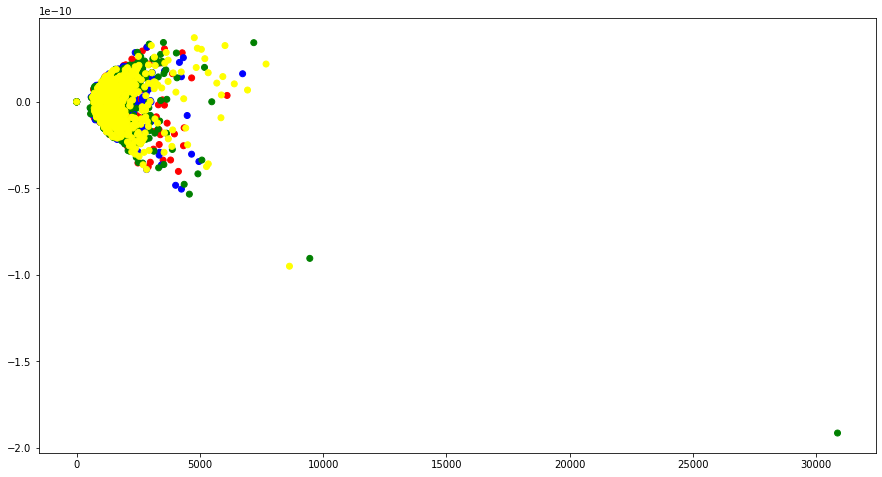

In [47]:
plt.figure(figsize=(15, 8))
plt.scatter(documentplot[:,0], documentplot[:,1], c=colors);

Documents of all types have their "outliers" which are farther away from the cluster at the beginning.

# 11.2

In [15]:
subsetindices=np.random.permutation(np.shape(X)[0])
Xsmall=X[subsetindices[0:1000],:].toarray() 

In [33]:
# Run t-SNE 

tsnemodel = sklearn.manifold.TSNE(n_components=2, verbose=1) 
tsneplot = tsnemodel.fit_transform(Xsmall)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.022s...
[t-SNE] Computed neighbors for 1000 samples in 0.160s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 15.164189
[t-SNE] KL divergence after 250 iterations with early exaggeration: 46.681835
[t-SNE] KL divergence after 1000 iterations: 0.176080


In [36]:
tsneplot

array([[ -7.7222605,  35.73478  ],
       [ -6.035409 ,  37.89663  ],
       [  2.403311 , -31.938929 ],
       ...,
       [-29.545778 ,  -9.686207 ],
       [-16.939117 , -25.50796  ],
       [-31.69658  ,  -6.2146106]], dtype=float32)

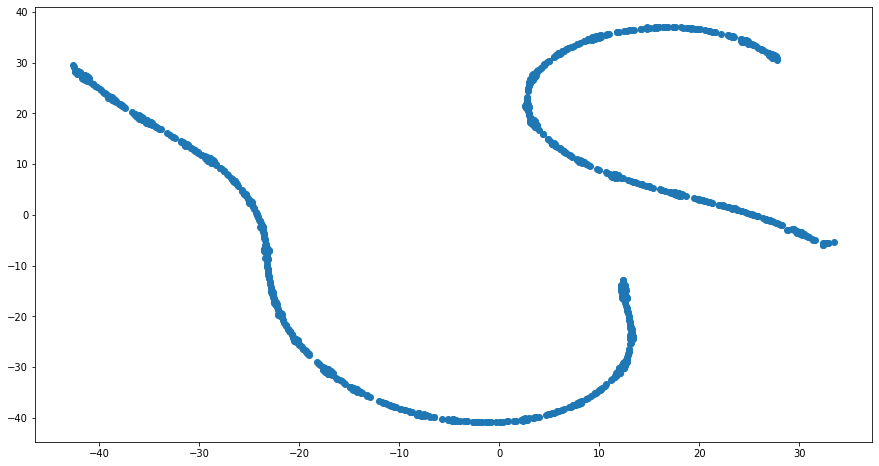

In [18]:
plt.figure(figsize=(15, 8))
plt.scatter(tsneplot[:,0], tsneplot[:,1]);

So I see two groups on the graph.

In [19]:
new_colors = []

for i in range(Xsmall.shape[0]):
    if subsetindices[i] < (n_docs / n_topics) :
        new_colors.append('red')
    elif (n_docs / n_topics) <= subsetindices[i] and subsetindices[i] < ((n_docs / n_topics) * 2):
        new_colors.append('blue')
    elif ((n_docs / n_topics) * 2) <= subsetindices[i] and subsetindices[i] < ((n_docs / n_topics) * 3):
        new_colors.append('green')
    else:
        new_colors.append('yellow')

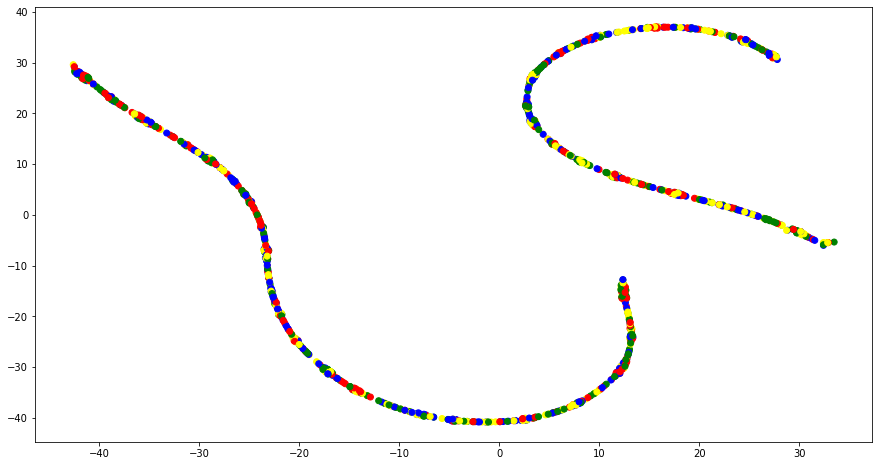

In [20]:
plt.figure(figsize=(15, 8))
plt.scatter(tsneplot[:,0], tsneplot[:,1], c=new_colors);

So there are no clusters with news types as we see from the coloured graph.

I got the bed result but I decided to try to reduce by t-SNE for unpruned texts and vocabulary.

In [10]:
X_not_pruning = tfidfmatrix_without_pruning.copy()
subsetindices_not_pruning = np.random.permutation(np.shape(X_not_pruning)[0])
Xsmall_not_pruning = X_not_pruning[subsetindices_not_pruning[0:1000],:].toarray() 

In [14]:
tsnemodel_not_pruning = sklearn.manifold.TSNE(n_components=2, verbose=1, perplexity=20, n_iter=400) 
tsneplot_not_pruning = tsnemodel_not_pruning.fit_transform(Xsmall_not_pruning)

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.036s...
[t-SNE] Computed neighbors for 1000 samples in 0.276s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 13.782523
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.532642
[t-SNE] KL divergence after 400 iterations: 0.229549


In [17]:
new_colors_not_pruning = []
n_topics = 4

for i in range(Xsmall_not_pruning.shape[0]):
    if subsetindices_not_pruning[i] < (n_docs / n_topics) :
        new_colors_not_pruning.append('red')
    elif (n_docs / n_topics) <= subsetindices_not_pruning[i] and subsetindices_not_pruning[i] < ((n_docs / n_topics) * 2):
        new_colors_not_pruning.append('blue')
    elif ((n_docs / n_topics) * 2) <= subsetindices_not_pruning[i] and subsetindices_not_pruning[i] < ((n_docs / n_topics) * 3):
        new_colors_not_pruning.append('green')
    else:
        new_colors_not_pruning.append('yellow')

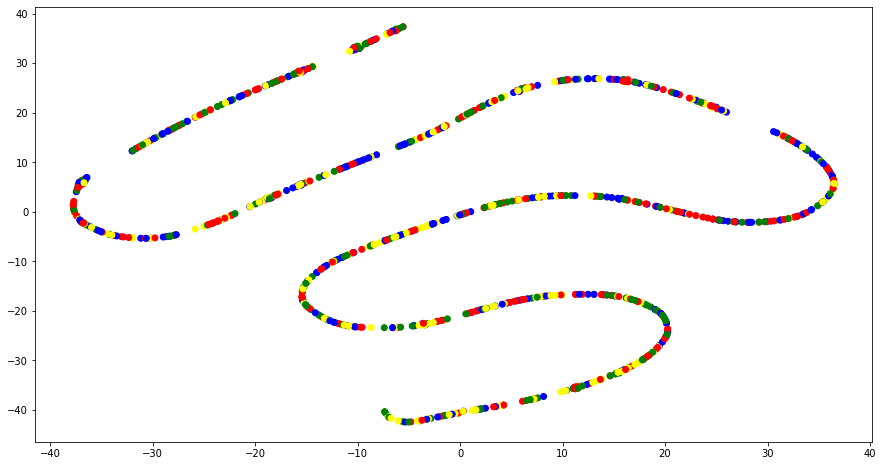

In [18]:
plt.figure(figsize=(15, 8))
plt.scatter(tsneplot_not_pruning[:,0], tsneplot_not_pruning[:,1], c=new_colors_not_pruning);

The result is still bad :( Because all types of news are mixed on these parts of the "wave".

# 11.3

Importing hmm sentences:

In [21]:
text_file = open('C:/disk_D/1_tampere_uni/text data analysis/hw/11/exercises11/hmm_sentences.txt')
sentences = text_file.readlines()

for i in range(len(sentences)):
    sentences[i] = nltk.Text(sentences[i].split())

Creating word2vec embeddings for the data:

In [31]:
import gensim

In [27]:
gensim_docs = sentences 
gensim_dictionary = gensim.corpora.Dictionary(gensim_docs) 
# Training algorithm: set to 0 for CBOW, 1 for skip-gram 
trainingalgorithm=0 
# Train the word2vec model 
word2vecmodel = gensim.models.word2vec.Word2Vec(sentences=gensim_docs, \
                                                vector_size=5, window=3, min_count=1, workers=4, sg=trainingalgorithm) 

Embadding for word "where":

In [28]:
word2vecmodel.wv['where']

array([-0.35410506,  0.9765728 ,  0.63569903, -0.6275945 ,  0.7030162 ],
      dtype=float32)

Embadding for word "dog":

In [29]:
word2vecmodel.wv['dog']

array([-0.10309548,  1.0337266 ,  0.5687526 , -0.32530427,  0.71391946],
      dtype=float32)

Embadding for word "explain":

In [30]:
word2vecmodel.wv['explain']

array([-0.09528832,  1.0046479 ,  0.82730836, -0.2992369 ,  0.77895266],
      dtype=float32)